Выполнила: Анастасия Плавина

## Урок 3. Связь бизнес-показателей и DS-метрик

### Цель 

Улучшение метрик предсказания сердечно-сосудистых заболеваний по результатам классического врачебного осмотра.


### Описание данных
Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

Объективные признаки:
 - Возраст
 - Рост
 - Вес
 - Пол
 

Результаты измерения:
 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 
 
 Субъективные признаки:
 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны. Все показатели даны на момент осмотра.
Последняя группа признаков не имеет однозначной интерпретации и более того, собрана со слов самого больного.

In [5]:
import numpy as np
import pandas as pd
import itertools

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(font_scale=1.5)
sns.set_color_codes("muted")


from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, learning_curve
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgbm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


### Загрузка данных

In [2]:
df = pd.read_csv('train_case2.csv', ';')
print(df.shape)
df.head(5)

(70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [3]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

### Создание pipeline

In [6]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [7]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

### Обучим различные классификаторы

In [8]:
def get_score(classifier):
    classifier = Pipeline([
    ('features',feats),
    ('classifier', classifier),
        ])


    #запустим кросс-валидацию
    cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
    cv_score = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)
    print('CV score is {}+-{}'.format(cv_score, cv_score_std))

    #обучим пайплайн на всем тренировочном датасете
    classifier.fit(X_train, y_train)
    y_score = classifier.predict_proba(X_test)[:, 1]
    
    return y_score
    

In [10]:
%%time


print('LogRegression:')
logreg_score = get_score(LogisticRegression(random_state = 42))
print('AdaBoost:')
ada_score = get_score(AdaBoostClassifier(random_state=42))
print('LGBM:')
lgbm_score = get_score(lgbm.LGBMClassifier(random_state=42))
print('GradientBoosting:')
gbc = get_score(GradientBoostingClassifier(random_state=42))

LogRegression:
CV score is 0.7867401104915408+-0.00852135511666111
AdaBoost:
CV score is 0.7952419477681905+-0.0071441451920620375
LGBM:
CV score is 0.8024619512142214+-0.007068221093288977
GradientBoosting:
CV score is 0.8025125910838183+-0.00707472977074522
CPU times: user 2min 53s, sys: 13.7 s, total: 3min 7s
Wall time: 3min 1s


Лучшие результаты у градиентного бустинга - потюним параметры

In [11]:
# %%time
# params = {'n_estimators':[50, 100, 200],
#           'max_depth':[3, 5, 7]}

# cv=KFold(n_splits=3, random_state=42, shuffle=True)

# gscv = GridSearchCV(GradientBoostingClassifier(), params, scoring='roc_auc', cv=cv, n_jobs=-1)
# gscv.fit(X_train, y_train)

In [12]:
# gscv.best_params_

In [13]:
gbc = get_score(GradientBoostingClassifier(random_state=42, max_depth=3, n_estimators=200))

CV score is 0.8025445512019656+-0.007048426808441478


#### Сохраним все предсказания

In [23]:
scores = {'LogReg': logreg_score, 'AdaBoost': ada_score, 'LGBM': lgbm_score,
         'GradientBoosting': gbc}

scores

{'LogReg': array([0.21919629, 0.24759828, 0.40484498, ..., 0.16941878, 0.70519218,
        0.75098778]),
 'AdaBoost': array([0.49276097, 0.49343602, 0.49719762, ..., 0.49260348, 0.50477394,
        0.50811146]),
 'LGBM': array([0.15569511, 0.17603565, 0.36073502, ..., 0.11258218, 0.7935991 ,
        0.78755573]),
 'GradientBoosting': array([0.15462197, 0.19208147, 0.35951164, ..., 0.11929698, 0.74176718,
        0.77467317])}

### Оценка работы модели

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [25]:
def eval_roc_auc_curve(scores, b=1):
    
    """оценка метрик различных моделей - метрики, кривая roсauc и матрица ошибок
    scores: предсказания
    b: вес метрики
    
    """
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    results = []
    for model in scores:
        
        # метрики каждой модели
        print(model)
        print('-------------------------------')
        b=b
        precision, recall, thresholds = precision_recall_curve(y_test.values, scores[model])
        fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
        # locate the index of the largest f score
        ix = np.argmax(fscore)
        print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f\n' % (thresholds[ix], 
                                                                                fscore[ix],
                                                                                precision[ix],
                                                                                recall[ix]))


        rocauc = roc_auc_score(y_true=y_test, y_score=scores[model])
        logloss = log_loss(y_true=y_test, y_pred=scores[model])
        print(f"roc auc score: {rocauc}")
        print(f"log loss score: {logloss}\n")
        
        fpr, tpr, thresholds_ = roc_curve(y_test, scores[model], pos_label=1)
        lw = 2
        plt.plot(fpr, tpr, lw=lw, label=model)
        
        # сохраняем метрики
        metrics = {'model': model, 
                   'roc_auc': rocauc, 
                   'logloss': logloss,
                   'precision': precision[ix], 
                   'recall': recall[ix], 
                   'f_score': fscore[ix]}
        
        results.append(metrics)
        

    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
    plt.legend()
    plt.show()
    
    return results

#### Оценка roc-кривой

LogReg
-------------------------------
Best Threshold=0.386937, F-Score=0.730, Precision=0.647, Recall=0.838

roc auc score: 0.7840347790421852
log loss score: 0.5779604008230668

AdaBoost
-------------------------------
Best Threshold=0.497430, F-Score=0.738, Precision=0.692, Recall=0.789

roc auc score: 0.7945722371129712
log loss score: 0.6869766413646277

LGBM
-------------------------------
Best Threshold=0.355647, F-Score=0.740, Precision=0.667, Recall=0.830

roc auc score: 0.8011820838166295
log loss score: 0.5409625775691054

GradientBoosting
-------------------------------
Best Threshold=0.388025, F-Score=0.740, Precision=0.693, Recall=0.794

roc auc score: 0.8028728434538177
log loss score: 0.5392561065273271



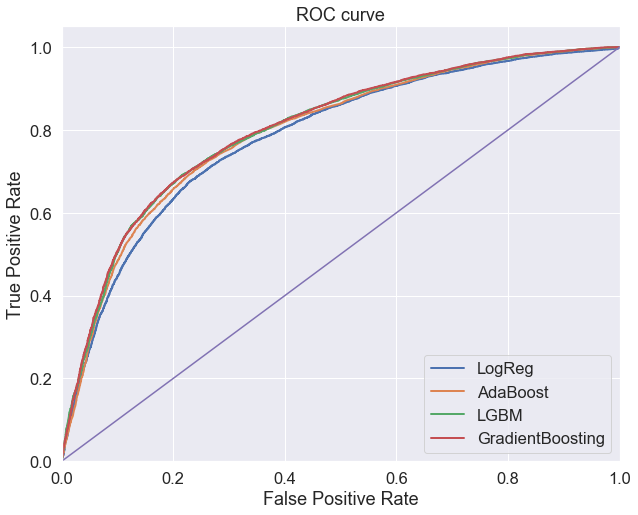

In [26]:
results = eval_roc_auc_curve(scores)

Видим, что лучший результат показывает градиентный бустинг - кривая наиболее смещена влево.

In [27]:
df_metrics = pd.DataFrame(results)
df_metrics

,model,roc_auc,logloss,precision,recall,f_score
0,LogReg,0.784035,0.577960,0.647431,0.837558,0.730323
1,AdaBoost,0.794572,0.686977,0.692471,0.789401,0.737766
2,LGBM,0.801182,0.540963,0.667099,0.829954,0.739668
3,GradientBoosting,0.802873,0.539256,0.693290,0.794009,0.740240


Градиентный бустинг показал лучшие результаты по метрике f1.

#### Посмотрим на матрицу ошибок

LogReg
TPR: 0.84, FPR: 0.45, TNR: 0.55
Confusion matrix, without normalization
[[4861 3959]
 [1411 7269]]


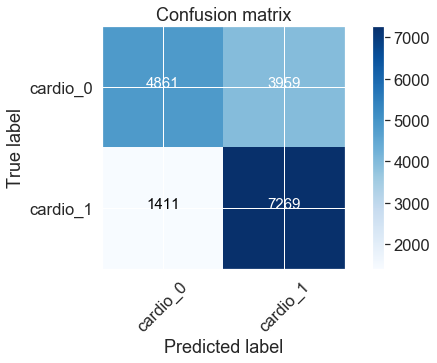

AdaBoost
TPR: 0.79, FPR: 0.35, TNR: 0.65
Confusion matrix, without normalization
[[5777 3043]
 [1829 6851]]


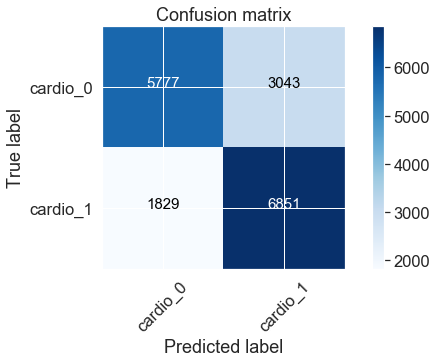

LGBM
TPR: 0.83, FPR: 0.41, TNR: 0.59
Confusion matrix, without normalization
[[5225 3595]
 [1477 7203]]


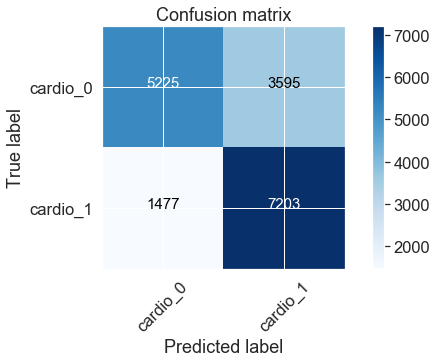

GradientBoosting
TPR: 0.79, FPR: 0.35, TNR: 0.65
Confusion matrix, without normalization
[[5771 3049]
 [1789 6891]]


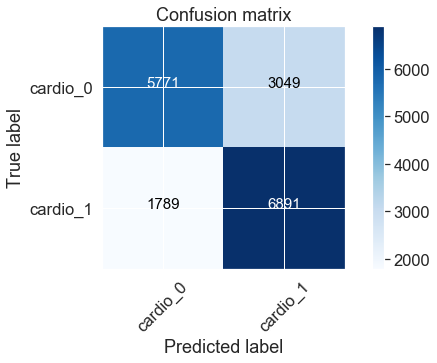

In [28]:
for model in scores:
    print(model)
    font = {'size' : 15}
    plt.rc('font', **font)
    precision, recall, thresholds = precision_recall_curve(y_test.values, scores[model])
    ix = np.argmax((1+1**2)*(precision * recall) / (1**2*precision + recall))
    cnf_matrix = confusion_matrix(y_test, scores[model]>thresholds[ix])
    TN = cnf_matrix[0][0]
    FN = cnf_matrix[1][0]
    TP = cnf_matrix[1][1]
    FP = cnf_matrix[0][1]
    TPR = TP/(TP+FN)
    FPR = FP/(FP+TN)
    TNR = TN/(FP+TN)
    print(f'TPR: {TPR:.2f}, FPR: {FPR:.2f}, TNR: {TNR:.2f}')
    
    plt.figure(figsize=(8, 5))
    plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                          title='Confusion matrix')
    plt.show()


В целом LGBM и градиентный бустинг показали самые хорошие результаты - все метрики очень близки, но  градиентный бустинг все же впереди по TPR и FPR.

**5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого).**

В случае сильного дисбаласа классов лучше смотреть на precision_recall_curve, т.к. tpr и fpr не чувствительны к дисбалансу и метрики могут быть высокими при низком precision и recall.